In [1]:
import pandas as pd, keras as k, numpy as np, matplotlib.pyplot as plt, os, re, glob

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Attention
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler

In [26]:

# read ./DATA/POST_DATA/all_data.csv
data = pd.read_csv('./POST_DATA/all_data.csv', encoding='cp949', index_col=0, parse_dates=True)

raw_index = data['유해남조류세포수'].dropna(axis=0).index

# apply log scale to '유해남조류세포수'
data['유해남조류세포수'] = np.log(data['유해남조류세포수'])

# convert nan or inf to 0 at '유해남조류세포수'
data['유해남조류세포수'] = data['유해남조류세포수'].replace([np.inf, -np.inf], 0)
data['유해남조류세포수'] = data['유해남조류세포수'].fillna(0)

# drop columns if nan is over 20%
data = data.dropna(axis=1, thresh=int(len(data)*0.5))

print(data.shape)

(48213, 16)


c:\Users\ympark\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
data

,평균기온,최저기온,최고기온,최대풍속,평균풍속,수위_DAY,유량_DAY,수온,용존산소,총유기탄소,클로로필,보방류량_DAY,보유입량_DAY,보저수량_DAY,보저수위_DAY,유해남조류세포수
date,,,,,,,,,,,,,,,,
2012-01-01,2.7,-1.0,7.4,7.6,2.6,1.46,1080.95,NaN,NaN,NaN,NaN,0.0,0.0,0.0,3.15,0.0
2012-01-02,1.0,-3.5,7.1,4.3,1.7,1.42,998.95,NaN,NaN,NaN,NaN,0.0,0.0,0.0,3.15,0.0
2012-01-03,1.2,-1.2,4.7,6.2,2.2,1.45,1060.45,NaN,NaN,NaN,NaN,0.0,0.0,0.0,3.32,0.0
2012-01-04,-0.6,-2.5,2.5,5.7,3.1,1.47,1090.82,NaN,NaN,NaN,NaN,0.0,0.0,0.0,3.25,0.0
2012-01-05,-0.2,-4.3,5.2,4.7,2.2,1.48,1116.63,NaN,NaN,NaN,NaN,0.0,0.0,0.0,3.24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2023-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2023-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [28]:
x_features = data.iloc[:,:-1].shape[1]
print(x_features)

15


In [29]:
def create_dataset(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(axis=0, how='any', inplace=True)
    return agg

In [42]:
input_df = data.iloc[:,:-1].interpolate(method='linear')
otput_df = data[['유해남조류세포수']].fillna(0)

input_cols = input_df.columns

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(input_df)
input_df = pd.DataFrame(scaled, columns=input_df.columns, index=input_df.index)

input_df = create_dataset(input_df, n_in=7, n_out=0, dropnan=False)
otput_df = create_dataset(otput_df, n_in=0, n_out=1, dropnan=False)

model_df = pd.concat([input_df, otput_df], axis=1)

# sampling data from 유해남조류세포수. 50% is not zero and 50% is zero
# sampling_index = model_df[model_df['유해남조류세포수'] == 0].sample(frac=0.5).index
# sampling_index = sampling_index.append(model_df[model_df['유해남조류세포수'] != 0].index)
model_df = model_df.loc[raw_index].dropna(axis=0)


In [31]:
X = model_df.iloc[:,:-1].values.reshape(model_df.shape[0], 7, x_features)
y = model_df.iloc[:,-1].values.reshape(model_df.shape[0], 1)

print(X.shape, y.shape)


(62908, 7, 15) (62908, 1)


In [32]:
# train, validation, test 데이터셋으로 분할
train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# print all data shape
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(37744, 7, 15) (37744, 1)
(12581, 7, 15) (12581, 1)
(12583, 7, 15) (12583, 1)


In [33]:
import tensorflow as tf

class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.W1 = self.add_weight(name='W1', shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
        self.W2 = self.add_weight(name='W2', shape=(self.units, self.units), initializer='glorot_uniform', trainable=True)
        self.V = self.add_weight(name='V', shape=(self.units,), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        hidden_states = inputs
        score = tf.matmul(hidden_states, self.W1)
        score = tf.tanh(tf.matmul(score, self.W2))
        attention_weights = tf.nn.softmax(tf.matmul(score, tf.reshape(self.V, (-1, 1))), axis=1)
        context_vector = attention_weights * hidden_states
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

In [40]:
model = Sequential()

model.add(LSTM(64, input_shape=(7, X_train.shape[2]), return_sequences=True))
model.add(Attention(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

In [41]:

# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

# 모델 학습
es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min')

history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=64,
                    verbose=2,
                    validation_data=(X_val, y_val),
                    callbacks=[es])

# 모델 평가
mse_train = model.evaluate(X_train, y_train, verbose=0)
mse_val = model.evaluate(X_val, y_val, verbose=0)
mse_test = model.evaluate(X_test, y_test, verbose=0)

print("MSE Train:", mse_train)
print("MSE Validation:", mse_val)
print("MSE Test:", mse_test)

Epoch 1/200
590/590 - 5s - loss: 12.1621 - val_loss: 11.0188 - 5s/epoch - 9ms/step
Epoch 2/200
590/590 - 3s - loss: 9.9984 - val_loss: 10.0235 - 3s/epoch - 5ms/step
Epoch 3/200
590/590 - 3s - loss: 9.3641 - val_loss: 9.8608 - 3s/epoch - 5ms/step
Epoch 4/200
590/590 - 3s - loss: 8.9315 - val_loss: 9.3839 - 3s/epoch - 5ms/step
Epoch 5/200
590/590 - 3s - loss: 8.6339 - val_loss: 8.8681 - 3s/epoch - 5ms/step
Epoch 6/200
590/590 - 3s - loss: 8.3176 - val_loss: 8.4852 - 3s/epoch - 5ms/step
Epoch 7/200
590/590 - 3s - loss: 8.0853 - val_loss: 8.4637 - 3s/epoch - 5ms/step
Epoch 8/200
590/590 - 3s - loss: 7.9026 - val_loss: 8.1808 - 3s/epoch - 5ms/step
Epoch 9/200
590/590 - 3s - loss: 7.7288 - val_loss: 8.1968 - 3s/epoch - 5ms/step
Epoch 10/200
590/590 - 3s - loss: 7.5846 - val_loss: 7.8449 - 3s/epoch - 5ms/step
Epoch 11/200
590/590 - 3s - loss: 7.4297 - val_loss: 7.7118 - 3s/epoch - 5ms/step
Epoch 12/200
590/590 - 3s - loss: 7.2746 - val_loss: 7.9261 - 3s/epoch - 5ms/step
Epoch 13/200
590/590 -

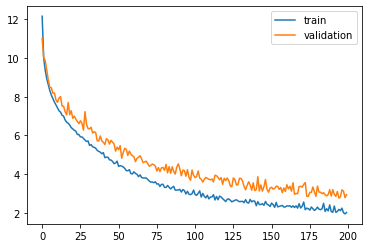

In [43]:
# plot the loss and accuracy
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


In [44]:
# prediction
y_pred = model.predict(X_test)
# y_pred = scaler.inverse_transform(y_pred)
# y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

394/394 [==============================] - 1s 2ms/step


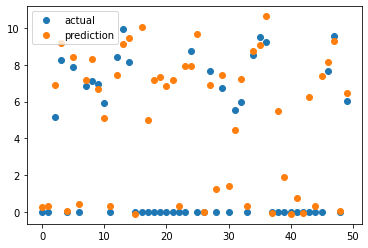

In [47]:
# plot the prediction
plt.plot(y_test[:50], 'o', label='actual')
plt.plot(y_pred[:50], 'o', label='prediction')
plt.legend()
plt.show()